# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [4]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [5]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [6]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f
help(autograd.jacobian)

Help on function jacobian in module autograd.wrap_util:

jacobian(fun, argnum=0, *nary_op_args, **nary_op_kwargs)
    Returns a function which computes the Jacobian of `fun` with respect to
    positional argument number `argnum`, which must be a scalar or array. Unlike
    `grad` it is not restricted to scalar-output functions, but also it cannot
    take derivatives with respect to some argument types (like lists or dicts).
    If the input to `fun` has shape (in1, in2, ...) and the output has shape
    (out1, out2, ...) then the Jacobian has shape (out1, out2, ..., in1, in2, ...).



Exemples d'usage :

In [7]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [8]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [9]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [10]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

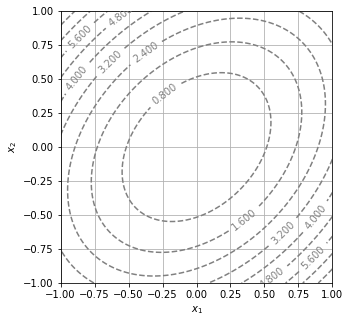

In [11]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [12]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

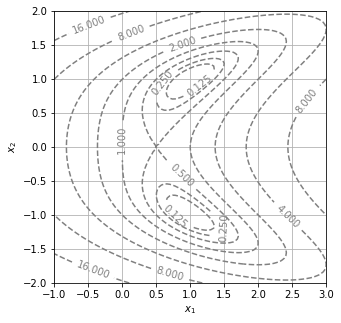

In [13]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [14]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

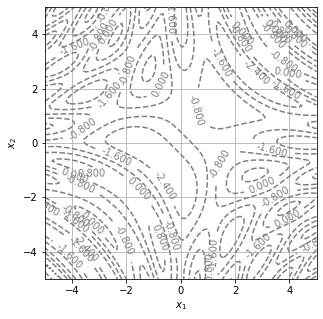

In [15]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [16]:
N = 100
eps = 10**(-15)

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [17]:
def Newton(F, x0, y0, eps=eps, N=N):
    L_x = [x0]
    L_y = [y0]
    for i in range(N):
        T = np.array([[x0], [y0]])
        T = (T - np.linalg.inv(J(F)(x0, y0))@F(T[0][0], T[1][0]))[0]
        x = T[0][0]
        y = T[1][0]
        L_x.append(x)
        L_y.append(y)
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return (x, y), np.array(L_x), np.array(L_y)
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

(0.4472135954999579, 0.4472135954999579)


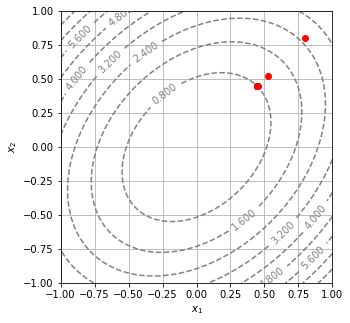

In [18]:
def F(x, y):
    return np.array([[f1(x, y) - 0.8], [x - y]])

p, L1, L2 = Newton(F, 0.8, 0.8, N=1000)
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
plt.plot(L1, L2, 'ro')
print(p)
plt.show()


### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [19]:
def level_curve(f, x0, y0, delta=0.1, N=100, eps=eps):
   x, y = x0, y0
   points = [[x, y]]
   for k in range (N):
      def F(u, v):
         return np.array([[f(u,v) - f(x, y)], [(u- 10**(-10) - x)**2 + (v-y)**2 - 2*10**(-10) - delta**2]]) #pour avoir une jacobienne inversible on perturbe légèrement nos fonctions (2*10**(-10))
      grad_f = grad(f)(x, y)
      p, L1, L2 = Newton(F, x + grad_f[1], y - grad_f[0], eps, 1000) #on translate le point de départ dans une direvtion orthogonale au grandient (vers la droite)
      x, y = p[0], p[1]
      points.append([x, y])
   return np.array(points).T
   

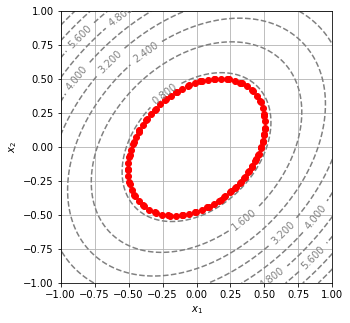

In [20]:

#test level_curve (avec comme point de départ (0.5, 0.1) qui est normalement proche de la ligne de niveau 0.8)

L = level_curve(f1, 0.5, 0.1, eps=10**(-5))
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

plt.plot(L[0], L[1], 'ro')
plt.show()


### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [21]:
def level_curve_bis(f, x0, y0, delta=0.1, N=1000, eps=eps):
   x, y = x0, y0
   points = [[x, y]]
   for k in range (N):
      def F(u, v):
         return np.array([[f(u,v) - f(x, y)], [(u- 10**(-10) - x)**2 + (v-y)**2 - 2*10**(-10) - delta**2]])
      grad_f = grad(f)(x, y)
      p, L1, L2 = Newton(F, x + grad_f[1], y - grad_f[0], eps, 1000) #on translate le point de départ dans une direvtion orthogonale au grandient (vers la droite)
      x, y = p[0], p[1]
      if (x -x0)**2 + (y - y0)**2 < (delta**2)/4 : # si on repasse trop proche du point de départ 
          break # on s'arrête
      points.append([x, y])
   return np.array(points).T

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

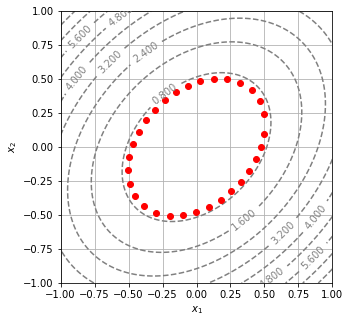

In [22]:
# test level_curve_bis sur f1 à partir du même point de départ (0.5, 0.1)

L = level_curve_bis(f1, 0.5, 0.1, eps=10**(-5))
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

plt.plot(L[0], L[1], 'ro')
plt.show()

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

L'aire approchée de l'ensemble des sous-niveaux de f1 associée à 0.8 est 0.9100000000000007


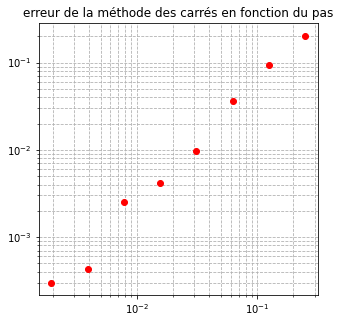

In [23]:
def area_squares(f,c,h = 0.1, N = 1):
    X = np.arange(-N, N, h)
    Y = np.arange(-N, N, h) # on quadrille le plan sur [-N; N]x[-N; N] avec pas h
    area = 0
    for x in X: #on parcourt le quadrillage à la recherche de points où f <= c
        for y in Y:
            if f(x, y) <= c: #lorsque le point du quadrillage vérifie la condition
                area += h**2 #on ajoute l'aire du carré de côté h
    return area

#test area_squares sur f1
print(f"L'aire approchée de l'ensemble des sous-niveaux de f1 associée à 0.8 est {area_squares(f1, 0.8, 0.1)}")

#test de convergence de la méthode des carrés pour le cercle unité
def cercle(x, y):
    return x**2 + y**2

for i in range (2, 10): 
    plt.plot(2**(-i), np.pi-area_squares(cercle, 1., 2**(-i)), 'ro')

plt.yscale('log')
plt.xscale('log') #échelle log-log

plt.grid(True,which="both", linestyle='--')

plt.title('erreur de la méthode des carrés en fonction du pas')
plt.show()


**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [24]:
def area_squares_encadrement(f,c,h = 0.1, N = 1):
    X = np.arange(-N, N, h)
    Y = np.arange(-N, N, h)
    area_min = 0
    area_max = 0
    for x in X:
        for y in Y:
            #pour la minoration il faut que tous les carrés autour soient sous la ligne de niveau
            if (f(x, y) <= c) and (f(x - h, y) <= c) and (f(x + h, y) <= c) and (f(x, y - h) <= c) and (f(x, y + h) <= c):
                area_min += h**2
            #pour la majoration il suffit que l'un des carrés autour soit sous la ligne de niveau
            if (f(x, y) <= c) or (f(x - h, y) <= c) or (f(x + h, y) <= c) or (f(x, y - h) <= c) or (f(x, y + h) <= c):
                area_max += h**2
    return area_min, area_max

def precision(f, c, prec, N = 1, it_max=100): 
    """ on réduit l'écart entre majorant et minorant de l'aire des sous-niveaux de f associée à c, jusqu'à obtenir un encadrement à la précision voulue """
    h = 0.1
    for k in range(it_max):
        min, max = area_squares_encadrement(f,c, h, N)
        if max - min < prec:
            return (f"{min} < area < {max} avec précision < {prec}")
        else:
            h = h/5
    return ("precision trop petite")

In [25]:
#test d'encadrement de l'aire du cercle unité (pi)
precision(cercle, 1., 0.01) #attention durée ~ 45s

'3.136956800352584 < area < 3.1458784003540785 avec précision < 0.01'

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [26]:
# on prend p = (0, 0)
def prod_vect(u,v):
  """ calcule u vectoriel v """
  return np.array([u[1]*v[2] - v[1]*u[2], u[2]*v[0] - v[2]*u[0], u[0]*v[1] - v[0]*u[1] ])

def norme (v):
  """ retourne la norme du vecteur v (en dimension 3)"""
  return np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)

def aire_du_triangle(a, b, c):
  """ calcule l'aire du triangle de sommets a, b, c"""
  u = b-a
  v = c-a
  u_dim3 = np.array([u[0], u[1], 0])
  v_dim3 = np.array([v[0], v[1], 0])
  return 0.5*norme(prod_vect(u_dim3, v_dim3)) #aire d'un parallélogramme de cotés u et v est la norme de u vectoriel v

def area_triangles(L, p = np.array([0., 0.])): #L : la liste de points décrivant le contour de K
  area = 0
  for i in range (-1, len(L)-1): # on ballaye tous les points de L en conservant l'indice i+1 dans la liste
     area += aire_du_triangle(p, np.array(L[i]), np.array(L[i+1]))
  return area




L'aire du cerlce unité mesuré à l'aide de la méthode des triangles est 3.136378488477257 pour un pas de 0.1 entre les points du contour


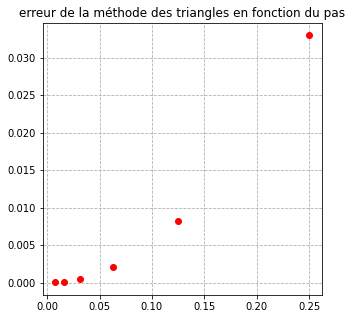

In [27]:
#test de area_triangles pour le cercle unité
print(f"L'aire du cerlce unité mesuré à l'aide de la méthode des triangles est {area_triangles(level_curve_bis(cercle, 1., 0.).T)} pour un pas de 0.1 entre les points du contour")

#on fait varier le pas entre les points et on regarde l'erreur
for i in range (2, 8): 
    plt.plot(2**(-i), np.pi-area_triangles(level_curve_bis(cercle, 0., 1., 2**(-i)).T), 'ro')

plt.grid(True,which="both", linestyle='--')

plt.title('erreur de la méthode des triangles en fonction du pas')
plt.show()

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [28]:
def area_triangles_bis(L, p = np.array([1., 1.])):
  area = 0
  for i in range (-1, len(L)-1): # on ballaye tous les points de L en conservant l'indice i+1 dans la liste
      u = L[i]-p
      v = L[i+1]-p
      u_dim3 = np.array([u[0], u[1], 0])
      v_dim3 = np.array([v[0], v[1], 0])
      area += 0.5*prod_vect(u_dim3, v_dim3)[-1] #le produit vectoriel contient dans sa troisième composante l'aire algébrique du triangle
  return abs(area)

L'aire du cerlce unité mesuré à l'aide de la méthode des triangles est 3.136378488477257 pour un pas de 0.1 entre les points du contour


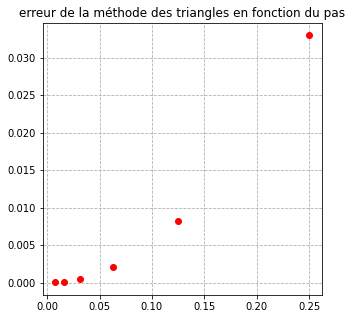

In [29]:
#test de area_triangles pour le cercle unité avec p = (1, 1)
print(f"L'aire du cerlce unité mesuré à l'aide de la méthode des triangles est {area_triangles_bis(level_curve_bis(cercle, 1., 0.).T, np.array([1., 1.]))} pour un pas de 0.1 entre les points du contour")

#on fait varier le pas entre les points et on regarde l'erreur
for i in range (2, 8): 
    plt.plot(2**(-i), np.pi-area_triangles_bis(level_curve_bis(cercle, 0., 1., 2**(-i)).T, np.array([1., 1.])), 'ro')

plt.grid(True,which="both", linestyle='--')

plt.title('erreur de la méthode des triangles en fonction du pas')
plt.show()

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

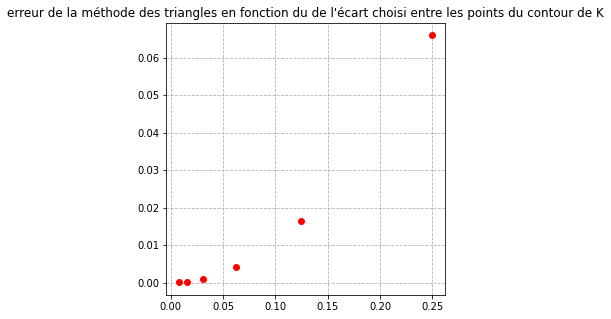

In [55]:
# test de la méthode des triangles sur un ensemble de deux cercles (ensemble non convexe)

for j in range (2, 8):
    L1 = level_curve_bis(cercle, 1., 0., delta = 2**(-j), eps=10**(-5)).T #cercle 1 : de centre (0;0) et de rayon 1
    L2 = np.array([[2 + L1[i][0], L1[i][1]] for i in range (len(L1))]) #cercle 2 (symétrique du cercle 1 par rapport à la droite x = 1)
    L  = np.concatenate((L1, L2), axis=0)

# clacul de l'erreur de la méthode des triangles sur cet ensemble
    plt.plot(2**(-j),(2*np.pi - area_triangles_bis(L, np.array([1., 0.]))), 'ro')

plt.grid(True,which="both", linestyle='--')

plt.title("erreur de la méthode des triangles en fonction du de l'écart choisi entre les points du contour de K")
plt.show()
print("La méthode semble bien fonctionner avec des ensembles non convexes.")

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

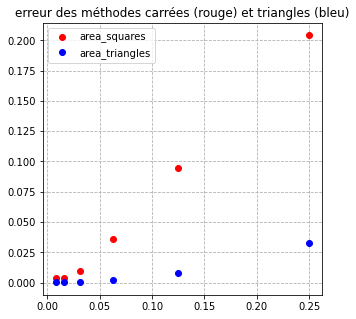

La méthode des triangles converge plus vite (en moins d'itérations) que la méthode des carrées.


In [45]:
#test de convergence des méthodes carrées et triangles pour le cercle unité
def cercle(x, y):
    return x**2 + y**2

for i in range (2, 7): 
    plt.plot(2**(-i), np.pi-area_squares(cercle, 1., 2**(-i)), 'ro')
    plt.plot(2**(-i), np.pi-area_triangles(level_curve_bis(cercle, 0., 1., 2**(-i)).T), 'bo')

plt.grid(True,which="both", linestyle='--')

plt.title('erreur des méthodes carrées (rouge) et triangles (bleu)')
plt.plot(2**(-7), np.pi-area_squares(cercle, 1., 2**(-i)), 'ro', label = 'area_squares')
plt.plot(2**(-7), np.pi-area_triangles(level_curve_bis(cercle, 0., 1., 2**(-i)).T), 'bo', label = 'area_triangles')
plt.legend()
plt.show()


print("La méthode des triangles converge plus vite (en moins d'itérations) que la méthode des carrées.")

In [ ]:
#test de convergence des méthodes carrées et triangles pour le cercle unité
def cercle(x, y):
    return x**2 + y**2

import time

start = time.time()
for i in range (2, 8): 
    a = np.pi-area_squares(cercle, 1., 2**(-i))
finish = time.time()
print(f"La méthode des carrées a pris {finish - start} s sur la fonction cercle pour différentes valeurs.")

start = time.time()
for i in range( 2, 8):
    a = np.pi-area_triangles(level_curve_bis(cercle, 0., 1., 2**(-i)).T)
finish = time.time()
print(f"La méthode des triangles a pris {finish - start} s sur la fonction cercle pour les mêmes valeurs.")
print("La méthode la plus rapide (en temps) est donc celle des carrées.")

La méthode des carrées a pris 0.10400629043579102 sur la fonction cercle pour différentes valeurs.
La méthode des triangles a pris 45.26794481277466 sur la fonction cercle pour les mêmes valeurs.
La méthode la plus rapide est donc celle des carrées.


In [ ]:
#test de convergence des méthodes carrées et triangles pour le cercle unité
def cercle(x, y):
    return x**2 + y**2

import time

start = time.time()
for i in range (2, 8): 
    a = np.pi-area_squares(cercle, 1., 2**(-i))
finish = time.time()
print(f"La méthode des carrées a pris {finish - start} s sur la fonction cercle pour différentes valeurs.")

t = 0
for i in range( 2, 8):
    L = level_curve_bis(cercle, 0., 1., 2**(-i)).T
    start = time.time()
    a = np.pi-area_triangles(L)
    finish = time.time()
    t += (finish - start)

print(f"La méthode des triangles sans prendre en compte le temps d'exécution de level_curve a pris {t} s sur la fonction cercle pour les mêmes valeurs.")
print("Les méthodes sont donc, dans le cadre de cette comparaison, équivalente en temps d'exécution.")

La méthode des carrées a pris 0.1076054573059082 sur la fonction cercle pour différentes valeurs.
La méthode des triangles a pris 0.1916205883026123 sur la fonction cercle pour les mêmes valeurs.
La méthode la plus rapide (en temps) est donc celle des carrées.
